https://github.com/hpparvi/ull_exoexo_2021/blob/main/01_rv_analysis.ipynb

https://exofop.ipac.caltech.edu/tess/target.php?id=470381900

In [1]:
import numpy as np
import matplotlib.pyplot as pl

import seaborn as sb
sb.set(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})
sb.set_context(rc={'lines.markeredgewidth': 1})

import matplotlib.pyplot as pl
pl.rcParams['font.size'] = 26

## Fitting upper limit of RV amplitude

In [2]:
# values from paper
Porb = 2.500311, 0.000004
tc = 2458816.697706, 0.0027523146

In [3]:
import pandas as pd

band = 'h'
# fp = "../data/rv/TOI1696_rv_all.dat"
fp = f"../data/rv/TOI1696_rv_{band}_new.dat"
df = pd.read_csv(fp,
                 skiprows=[1] # <------------------first datapoint is 243 d apart from rest!
                )
df['rv'] = df['rv']*1000
df['rv_err'] = df['rv_err']*1000
df

,bjd,rv,rv_err
0,2.459488e+06,79.955,8.17
1,2.459508e+06,66.788,10.87
2,2.459508e+06,26.116,8.23
3,2.459510e+06,62.113,10.18
4,2.459510e+06,-1.363,8.54
5,2.459515e+06,-1.412,9.39
6,2.459515e+06,-29.998,8.43
7,2.459531e+06,-74.507,9.47
8,2.459589e+06,1.363,9.36


In [4]:
np.std(df['rv'])

47.14023349565301

In [5]:
df.bjd.diff()

0          NaN
1    19.961093
2     0.149916
3     1.825067
4     0.170287
5     4.860434
6     0.198360
7    15.721695
8    57.881201
Name: bjd, dtype: float64

In [6]:
#def fold_index(time, period, tc=0, phase_offset=0.5):
#    phase = (((((time - tc) / period) + phase_offset) % 1) / phase_offset) - 1
#    idx = np.argsort(phase)
#    return phase[idx], idx

def fold_index(time, period, tc=0):
    phase = []
    
    for t in time:
        
        ph = ((t-tc)%period)/period
        if ph > 0.5:
            ph = ph - 1.
            
        phase.append(ph)
        
    idx = np.argsort(phase)
    phase = np.sort(phase)
    
    return phase*period, idx

## test dataset
* uncomment below to test RV model

<AxesSubplot:xlabel='bjd'>

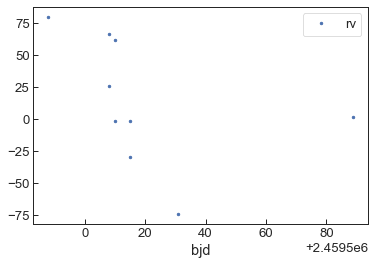

In [7]:
df.plot(x='bjd',y='rv',marker='.',ls='')

In [8]:
n=round((df.bjd[0]-tc[0])/Porb[0])
n

268

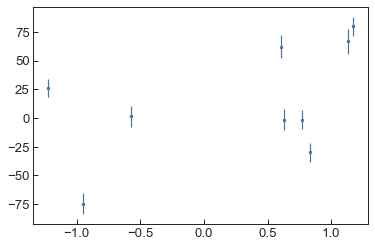

In [9]:
tc_new = tc[0]+n*Porb[0] 
phase, idx = fold_index(df.bjd, Porb[0], tc=tc_new) 
pl.errorbar(phase, df.rv[idx], yerr=df.rv_err[idx], fmt='.');

## periodogram

In [10]:
import pandas as pd
import astropy.units as u
from astropy.timeseries import LombScargle

In [11]:
ls = LombScargle(df['bjd'], df['rv'])

In [12]:
# frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
frequency, power = ls.autopower(minimum_frequency=1/5, maximum_frequency=2)
period = 1/frequency

In [13]:
best_period = period[np.argmax(power)]
best_period

0.9825890343765604

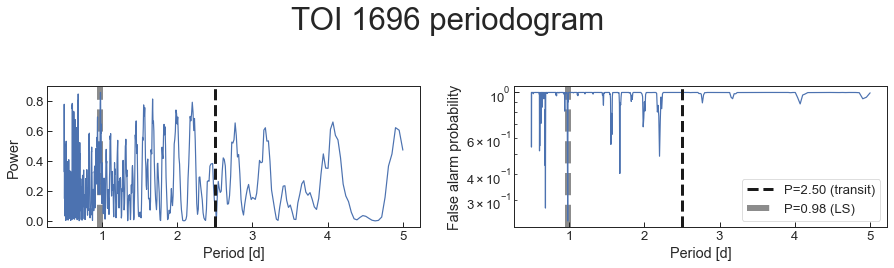

In [14]:
target = 'TOI 1696'

fig, axs = pl.subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(Porb[0], 0, 1, ls='--', lw=3, c='k', label=f"P={Porb[0]:.2f} (transit)") for ax in axs]
[ax.axvline(best_period, c='k', ls='--', zorder=-1, lw=6, alpha=0.5, label=f"P={best_period:.2f} (LS)") for ax in axs]
pl.legend()
pl.setp(axs, xlabel='Period [d]')
pl.setp(axs[0], ylabel='Power')
pl.setp(axs[1], ylabel='False alarm probability')
fig.suptitle(f'{target} periodogram')
fig.tight_layout()

Periodogram cannot detect the period from transit

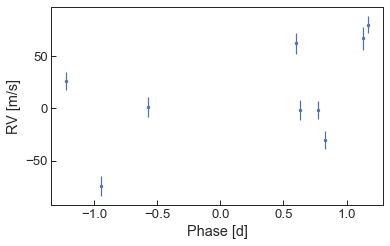

In [15]:
fig, ax = pl.subplots()

phase, idx = fold_index(df.bjd.values, Porb[0], tc=tc_new) 

ax.errorbar(phase, df.rv[idx], df.rv_err[idx], fmt='.')
# plt.errorbar(phase_time, phase_rv_val, yerr=phase_rv_err, fmt='.')
pl.setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

## LPF

In [16]:
from pytransit.lpf.rvlpf import RVLPF

In [17]:
inst = 'ird'
use_tc_offset=False

if use_tc_offset:
    offset=tc[0]+n*Porb[0]
else:
    offset=0
lpf = RVLPF(target, 
            nplanets=1, 
            times=df['bjd'].values-offset,#*u.day, 
            rvs=df['rv'].values,#*u.m/u.second, 
            rves=df['rv_err'].values,#*u.m/u.second,
            rvis=[inst]
           )
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_ird   N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_ird     U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

## test model

<ErrorbarContainer object of 3 artists>

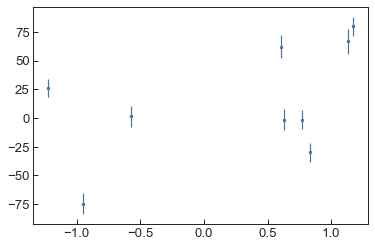

In [21]:
pv = [tc_new, Porb[0], 
      -0.5, -0.5, #sqrt(e)*cos(w), sqrt(e)*sin(w)
      0, 0, 20, 0]
N = 5000
x = np.linspace(df.bjd.min(),df.bjd.max(), N)
y = lpf.rvm.rv_model(pv, x, add_sv=False, add_slope=False)
phase, idx = fold_index(df.bjd, Porb[0], tc=tc_new) 

pl.errorbar(phase, df.rv[idx], df.rv_err[idx], fmt='.')

In [24]:
N=10_000
d_tc = np.random.rand(N)*tc[1]+tc[0]
d_P = np.random.rand(N)*Porb[1]+Porb[0]
tc_err = np.std(d_tc+n*d_P)
tc_err

0.000854017366766008

In [25]:
lpf.set_prior('tc_1', 'NP', tc[0]+n*Porb[0], tc_err)
lpf.set_prior('p_1', 'NP', *Porb)
lpf.set_prior('rv_k_1', 'UP', 0.0, 500)        # main parameter of interest
lpf.set_prior(f'rv_shift_{inst}', 'UP', -100, 100)   # unknown
lpf.set_prior(f'rv_err_{inst}', 'UP', 0, 500)
lpf.set_prior('rv_slope', 'NP', 0, 0.001)        # essentially fixed
lpf.set_prior('secw_1', 'NP', 0, 0.001)         # essentially fixed, omega=ecc=0
lpf.set_prior('sesw_1', 'NP', 0, 0.001)         # essentially fixed
lpf.ps

[  0 |G| tc_1           N(μ = 2459486.781054, σ = 0.000854017366766008) [    -inf ..      inf],
   1 |G| p_1            N(μ = 2.500311, σ = 4e-06)               [    0.00 ..      inf],
   2 |G| secw_1         N(μ = 0.0, σ = 0.001)                    [   -1.00 ..     1.00],
   3 |G| sesw_1         N(μ = 0.0, σ = 0.001)                    [   -1.00 ..     1.00],
   4 |G| rv_shift_ird   U(a = -100, b = 100)                     [    -inf ..      inf],
   5 |G| rv_err_ird     U(a = 0, b = 500)                        [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 500)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 0.001)                    [    -inf ..      inf]]

Global optimisation:   0%|          | 0/1000 [00:00<?, ?it/s]

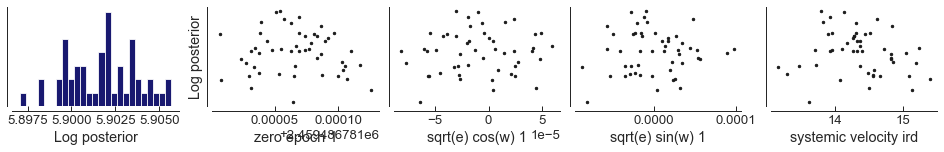

In [26]:
lpf.optimize_global(1000)

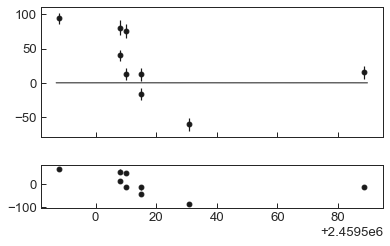

In [27]:
fig = lpf.plot_rv_vs_time(method='de')

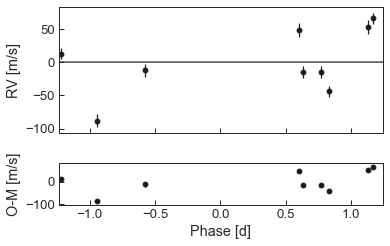

In [28]:
fig = lpf.plot_rv_vs_phase(planet=0, method='de', ntimes=500);

## mcmc

In [60]:
lpf.sample_mcmc(niter=10000, thin=10, repeats=10)

MCMC sampling:   0%|          | 0/10 [00:00<?, ?it/s]

Run 1/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 2/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 3/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 4/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 5/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 6/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 7/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 8/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 9/10:   0%|          | 0/10000 [00:00<?, ?it/s]

Run 10/10:   0%|          | 0/10000 [00:00<?, ?it/s]

emcee: Exception while calling your likelihood function:
  params: [[ 2.45948678e+06  2.50030957e+00 -8.10926580e-05  1.73832786e-04
   3.25289124e+01  7.06557201e+01  3.72404075e+01 -7.32160026e-04]
 [ 2.45948678e+06  2.50030626e+00 -1.83608232e-04  1.10379023e-03
  -1.49339956e+01  5.17808985e+01  7.09131750e+00  6.89562172e-04]
 [ 2.45948678e+06  2.50031543e+00 -1.93552403e-03 -1.52392359e-03
   3.43652461e+01  5.83957012e+01  3.53698276e+00  7.94190714e-04]
 [ 2.45948678e+06  2.50030925e+00  1.04091738e-04  6.49047676e-04
   5.33275579e+00  8.34704658e+01  5.11765999e+00  1.90780557e-04]
 [ 2.45948678e+06  2.50030739e+00 -1.03853467e-03  1.35108587e-03
   1.05656827e+01  5.24284273e+01  6.62748758e+00  1.02168066e-06]
 [ 2.45948678e+06  2.50030861e+00  9.29651944e-04  1.03583619e-03
  -5.69891796e+00  7.83302120e+01  1.16210634e+01 -3.83112186e-04]
 [ 2.45948678e+06  2.50031392e+00 -1.26112117e-04 -4.68655014e-04
   1.57628150e+01  6.68489652e+01  4.27197729e+00  7.62048855e-04]
 [

Traceback (most recent call last):
  File "/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/pytransit/lpf/logposteriorfunction.py", line 122, in lnposterior
    lnp = self.lnprior(pv) + self.lnlikelihood(pv)
  File "/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/pytransit/lpf/rvlpf.py", line 86, in lnlikelihood
    return squeeze(self.rvm.lnlikelihood(pv))
  File "/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/pytransit/lpf/rvlpf.py", line 231, in lnlikelihood
    return lnlike_normal(self._rva, self.rv_model(pvp), errors)
  File "/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/pytransit/lpf/rvlpf.py", line 220, in rv_model
    ta = ta_newton_v(times, t0=tc[ipv], p=p[ipv], e=e[ipv], w=w[ipv])
KeyboardInterrupt


KeyboardInterrupt: 

## posterior model

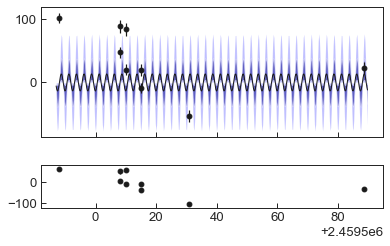

In [31]:
fig = lpf.plot_rv_vs_time(method='mcmc');

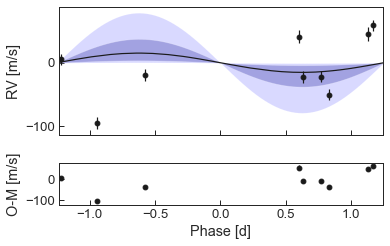

In [32]:
fig = lpf.plot_rv_vs_phase(planet=0, method='mcmc', ntimes=500)

## RV amplitude upper limit

In [33]:
lpf.ps.names

['tc_1',
 'p_1',
 'secw_1',
 'sesw_1',
 'rv_shift_ird',
 'rv_err_ird',
 'rv_k_1',
 'rv_slope']

In [34]:
HALF_PI = 0.5 * np.pi
TWO_PI = 2 * np.pi

def secw(e, w):
    return np.sqrt(e)*np.cos(w)

def sesw(e, w):
    return np.sqrt(e)*np.sin(w)

def ecc(secw, sesw):
    return secw**2+sesw**2

def omega(sesw, secw):
    return np.arctan2(sesw, secw)

def rv_model(t, t0, p, e, w, k, k0):    
    """
    M = 2*np.pi/P * (t - tp)
    E = E_sol(e, M)

    f = 2*np.arctan(((1+e)/(1-e))**0.5 * np.tan(E/2))

    rv = K*( np.cos(f)*np.cos(pomega) - np.sin(f)*np.sin(pomega) + gamma + e*np.cos(pomega))
    """
    ta = ta_newton_v(t, t0, p, e, w)
    rv = k0 + k * (np.cos(w + ta) + e * np.cos(w))
    return rv
    
def ta_newton_v(t, t0, p, e, w):
    """
    """
    Ma = mean_anomaly(t, t0, p, e, w)
    Ea = Ma.copy()
    for j in range(len(t)):
        err = 0.05
        k = 0
        while abs(err) > 1e-8 and k<1000:
            err   = Ea[j] - e*np.sin(Ea[j]) - Ma[j]
            Ea[j] = Ea[j] - err/(1.0-e*np.cos(Ea[j]))
            k += 1
    
    sta = np.sqrt(1.0-e**2) * np.sin(Ea)/(1.0-e*np.cos(Ea))
    cta = (np.cos(Ea)-e)/(1.0-e*np.cos(Ea))
    
    return np.arctan2(sta, cta)

def mean_anomaly(t, t0, p, e, w):
    offset = mean_anomaly_offset(e, w)
    Ma = np.mod(TWO_PI * (t - (t0 - offset * p / TWO_PI)) / p, TWO_PI)
    return Ma

def mean_anomaly_offset(e, w):
    mean_anomaly_offset = np.arctan2(np.sqrt(1.0-e**2) * np.sin(HALF_PI - w), e + np.cos(HALF_PI - w))
    mean_anomaly_offset -= e*np.sin(mean_anomaly_offset)
    return mean_anomaly_offset

In [35]:
lpf.posterior_samples()['tc_1'].median()-(tc[0]+n*Porb[0])

6.6212378442287445e-06

In [36]:
df2 = lpf.posterior_samples()
if use_tc_offset:
    df2['tc_1'] = df2['tc_1']+lpf._tref
df2['ecc'] = ecc(df2['secw_1'], df2['sesw_1'])
df2['omega'] = np.rad2deg(omega(df2['secw_1'], df2['sesw_1']))
df2.median()

tc_1            2.459487e+06
p_1             2.500311e+00
secw_1          1.115899e-06
sesw_1         -4.627525e-06
rv_shift_ird    1.929999e+01
rv_err_ird      6.211964e+01
rv_k_1          1.440713e+01
rv_slope       -5.392556e-06
ecc             1.380660e-06
omega           1.412026e-01
dtype: float64

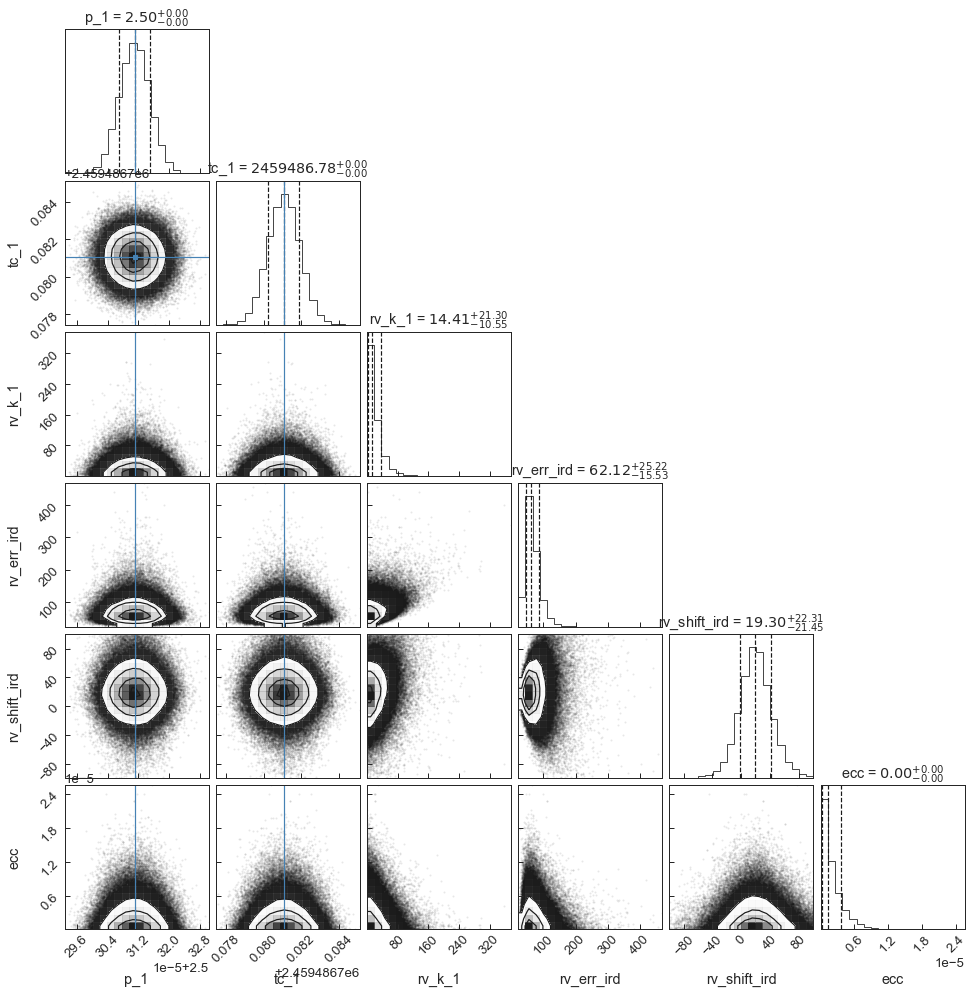

In [37]:
from corner import corner

cols = 'p_1 tc_1 rv_k_1 rv_err_ird rv_shift_ird ecc'.split()
truths = (Porb[0], tc[0]+n*Porb[0], None, None, None, None)
fig = corner(df2[cols], labels=cols, show_titles=True, truths=truths, quantiles=[0.16,0.50,0.84]);

In [38]:
pv = df2.median().values
pv

array([ 2.45948678e+06,  2.50031098e+00,  1.11589855e-06, -4.62752460e-06,
        1.92999905e+01,  6.21196430e+01,  1.44071350e+01, -5.39255646e-06,
        1.38066042e-06,  1.41202623e-01])

In [39]:
t0=pv[0]
p=pv[1]
e=ecc(pv[2],pv[3])
w=omega(pv[2],pv[3])
k0=pv[4]
k=pv[6]
k,kmax=np.percentile(df2.rv_k_1, [68,99.7])
N=500
t=np.linspace(df.bjd.min(),df.bjd.max(),N)
rv = rv_model(t, t0, p, e, w, k, k0)
rvmax = rv_model(t, t0, p, e, w, kmax, k0)

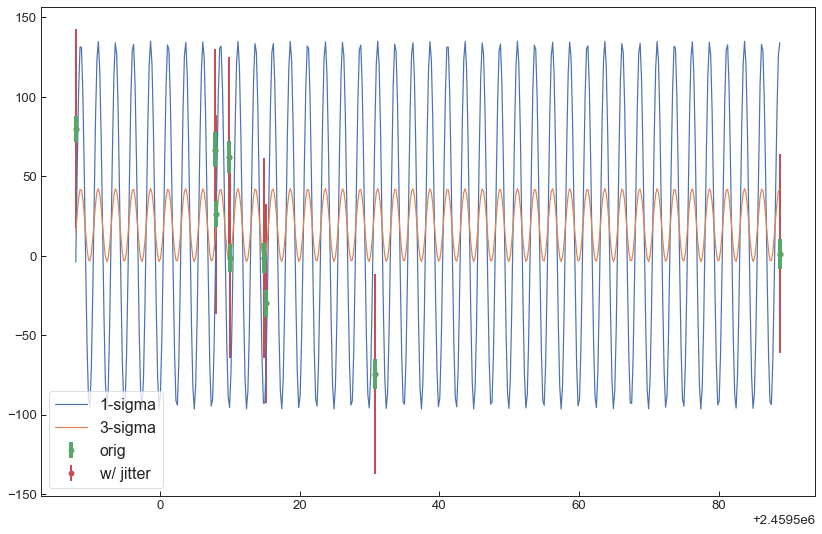

In [40]:
fig, ax = pl.subplots(figsize=(12,8))

rve = np.sqrt(df['rv_err']**2+pv[5]**2)
pl.plot(t, rvmax, '-', label='1-sigma')
pl.plot(t, rv, '-', label='3-sigma')
ax.errorbar(df['bjd'], df['rv'], df['rv_err'], fmt='o', lw=4, label='orig', zorder=3)
ax.errorbar(df['bjd'], df['rv'], rve, fmt='o', lw=2, label='w/ jitter', zorder=1)
pl.legend(fontsize=16)
fig.tight_layout()

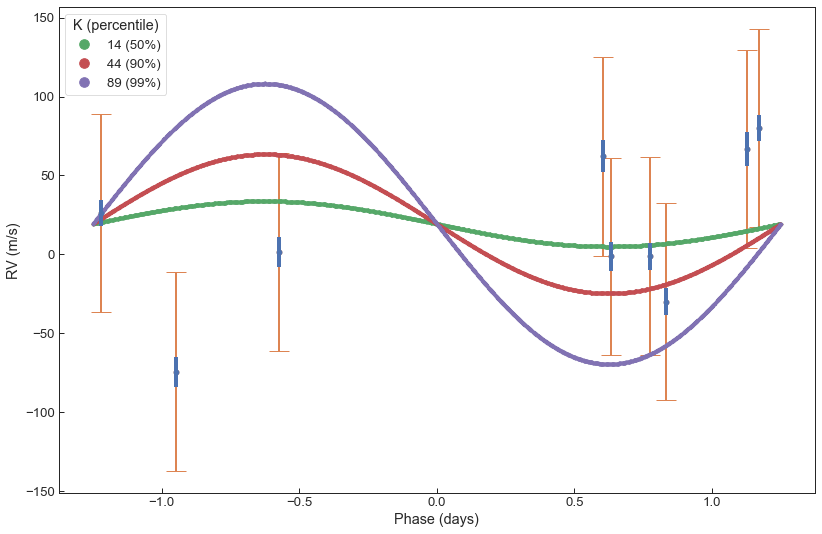

In [41]:
# pl.style.use('default')

fig, ax = pl.subplots(figsize=(12,8))

N = 5000
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase, idx = fold_index(t, Porb[0], tc=tc_new) 
phaseo, idxo = fold_index(df.bjd.values, Porb[0], tc=tc_new) 

ax.errorbar(phaseo, df.rv[idxo], df.rv_err[idxo], fmt='o', lw=4, zorder=3) #, label='orig err'
ax.errorbar(phaseo, df.rv[idxo], rve, fmt='o', lw=2, zorder=1, capsize=10) #, label='w/ jitter'

pctls = [50,90,99]
ks = np.percentile(df2.rv_k_1, pctls)
for k,i in zip(ks, pctls):
    rv = rv_model(t, t0, Porb[0], e, w, k, k0)
    ax.plot(phase, rv[idx], '.', label=f'{k:.0f} ({i}%)')
    
pl.legend(title='K (percentile)', markerscale=4)
pl.setp(ax, xlabel='Phase (days)', ylabel='RV (m/s)')
fig.tight_layout()

In [42]:
def get_Mp_from_K(Porb_samples, Ms_samples, K_samples, e=0, inc=np.pi/2):
    """
    """
    P = Porb_samples*u.day.to(u.second)*u.second
    Ms = Ms_samples*u.Msun.to(u.kg)*u.kg
    K = K_samples*(u.m/u.second)
    Mp_samples = ((P*Ms**2)/(2*np.pi*c.G))**(1/3)*(K*(1-e**2)**0.5)/np.sin(inc)
    return Mp_samples

In [43]:
import astropy.units as u
import astropy.constants as c

Mstar = (0.255, 0.007)
Kmax = (df2.rv_k_1.max()-df2.rv_k_1.min())/2
Kmax, get_Mp_from_K(Porb[0], Mstar[0], Kmax, e=0, inc=np.pi/2).to(u.Mearth).value

(187.91117213943537, 160.3831416070999)

In [44]:
K_samples = df2.rv_k_1.values
N = len(K_samples)
Ms_samples = np.random.rand(N)*Mstar[1]+Mstar[0]
Porb_samples = np.random.rand(N)*Porb[1]+Porb[0]
e_samples = np.zeros_like(K_samples)
inc_samples = np.ones_like(Ms_samples)*np.pi/2

Mp_samples = get_Mp_from_K(Porb_samples, Ms_samples, K_samples, e=e_samples, inc=inc_samples)

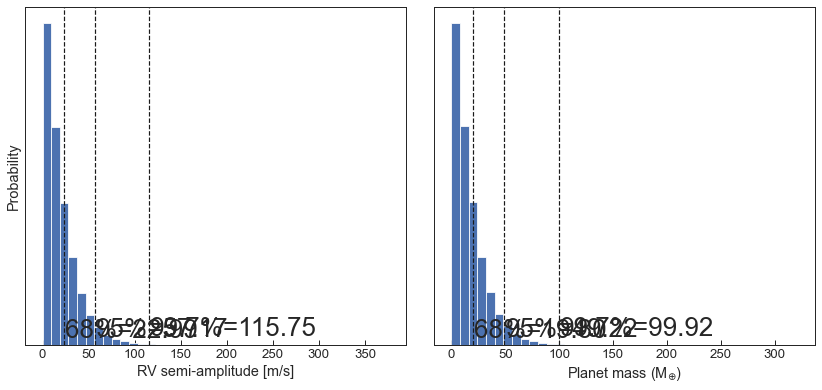

In [45]:
fig, axs = pl.subplots(1, 2, figsize=(12,6))

ax = axs[0]
ax.hist(df2.rv_k_1, bins=40)
# ax.axvline(np.median(df2.rv_k_1), c='k')
pctls = [68,95,99.7]
vals = np.percentile(df2.rv_k_1, pctls)
i=0
for p,v in zip(pctls,vals):
    ax.axvline(v, 0, 1, ls='--', c='k')
    ax.text(v+1, 2000+i,f"{p}%={v:.2f}")
    i+=300
pl.setp(ax, xlabel='RV semi-amplitude [m/s]', ylabel='Probability', yticks=[])

ax = axs[1]
Mp = Mp_samples.to(u.Mearth).value
ax.hist(Mp, bins=40)
vals = np.percentile(Mp, pctls)
i=0
for p,v in zip(pctls,vals):
    ax.axvline(v, 0, 1, ls='--', c='k')
    ax.text(v+1, 2000+i,f"{p}%={v:.2f}")
    i+=300
pl.setp(ax, xlabel='Planet mass (M$_{\oplus}$)', yticks=[]);
fig.tight_layout()

## Figure

/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-1.2497824320637285 -1.2494723984004246 -1.2487090289489018 ...
 1.2493118626965298 1.2497651984847487 1.2500752321480526] in fill_betweenx(). This will become an error two minor releases later.


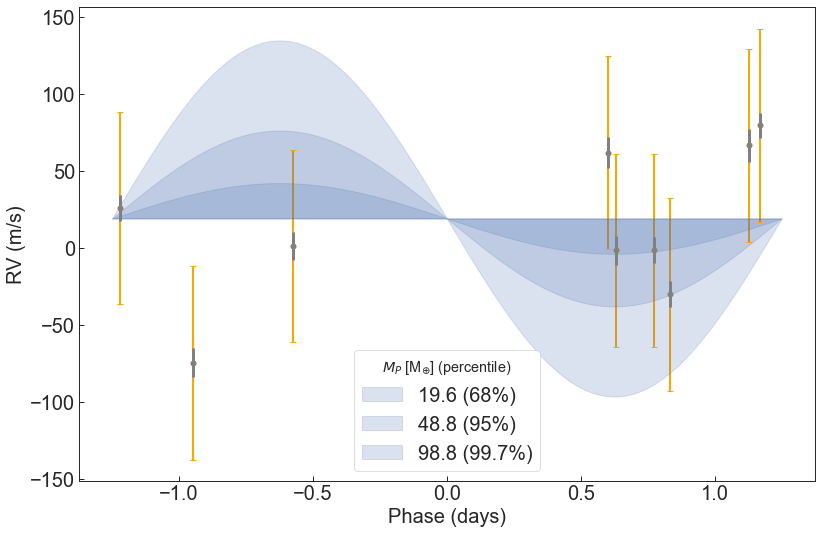

In [46]:
# pl.style.use('default')

fig, ax = pl.subplots(figsize=(12,8))

N = 5000
dt = 0.5
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase, idx = fold_index(t, Porb[0], tc=tc_new) 
phaseo, idxo = fold_index(df.bjd.values, Porb[0], tc=tc_new) 

ax.errorbar(phaseo, df.rv[idxo], df.rv_err[idxo], fmt='o', lw=3, zorder=3, color='gray') #, label='orig err'
ax.errorbar(phaseo, df.rv[idxo], rve, fmt='o', lw=2, zorder=1, capsize=3, color='orange') #, label='w/ jitter'

pctls = [68,95,99.7]
ks = np.percentile(df2.rv_k_1, pctls)

for i,k in zip(pctls,ks):
    Mp = get_Mp_from_K(Porb[0], Mstar[0], k, e=0, inc=np.pi/2).to(u.Mearth).value
    rv = rv_model(t, t0, Porb[0], e, w, k, k0)
    #ax.plot(phase, rv[idx], '-', lw=1, label=f'{Mp:.1f} ({i}%)', color='deepskyblue')
    ax.fill_between(phase, k0, rv[idx], '-', lw=1, label=f'{Mp:.1f} ({i}%)', color='C0', alpha=0.2)
pl.legend(title='$M_P$ [M$_{\oplus}$] (percentile)', markerscale=4, loc='lower center', fontsize=20)
#pl.setp(ax, xlabel='Phase (days)', ylabel='RV (m/s)', 
#          xlim=(-Porb[0]/2, Porb[0]/2)
#        )

ax.set_xlabel('Phase (days)',fontsize=20)
ax.set_ylabel('RV (m/s)',fontsize=20)

pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)

fig.tight_layout()

In [47]:
t = np.linspace(df.bjd.min(),df.bjd.max(), N)

In [48]:
df.rv_err*10

0     81.7
1    108.7
2     82.3
3    101.8
4     85.4
5     93.9
6     84.3
7     94.7
8     93.6
Name: rv_err, dtype: float64

In [61]:
get_Mp_from_K(Porb[0], Mstar[0], 14.41, e=0, inc=np.pi/2).to(u.Mearth).value

12.299008325292084

In [49]:
for i,k in zip(pctls,[0, 1, 5]):
    Mp = get_Mp_from_K(Porb[0], Mstar[0], k, e=0, inc=np.pi/2).to(u.Mearth).value
    rv = rv_model(df.bjd, t0, Porb[0], e, w, k, k0)
    
    chisq = np.sum(((rv - df.rv)/(df.rv_err))**2)/8.
    
    const = chisq**0.5
    
    after_chisq = np.sum(((rv - df.rv)/(df.rv_err*const))**2)/8.
    
    print(k, Mp, chisq, after_chisq, const)

0 0.0 29.911155267086865 1.0000000000000002 5.469109184052451
1 0.8535050885004916 30.051053113448845 1.0000000000000002 5.481884084276942
5 4.267525442502458 30.76412903765934 1.0000000000000002 5.546542079319271


In [50]:
5.4 * df.rv_err

0    44.118
1    58.698
2    44.442
3    54.972
4    46.116
5    50.706
6    45.522
7    51.138
8    50.544
Name: rv_err, dtype: float64

In [62]:
df2

,tc_1,p_1,secw_1,sesw_1,rv_shift_ird,rv_err_ird,rv_k_1,rv_slope,ecc,omega
0,2.459487e+06,2.500306,-0.000800,0.001467,37.363668,83.712921,34.581971,0.000797,2.791539e-06,-28.595809
1,2.459487e+06,2.500310,-0.000229,0.002598,17.939638,55.079431,6.579403,-0.000027,6.803050e-06,-5.031860
2,2.459487e+06,2.500310,-0.000200,0.002630,17.823061,54.625913,6.383776,-0.000002,6.957223e-06,-4.344649
3,2.459487e+06,2.500309,0.000547,0.002748,40.508253,42.324830,1.385339,-0.000156,7.850500e-06,11.258555
4,2.459487e+06,2.500310,0.000037,0.001293,26.632171,54.545108,4.128857,-0.001527,1.674467e-06,1.637669
...,...,...,...,...,...,...,...,...,...,...
249995,2.459487e+06,2.500320,-0.000187,-0.001227,1.482353,59.432012,10.671688,-0.002204,1.541068e-06,-171.341936
249996,2.459487e+06,2.500317,-0.000152,-0.001314,-0.246858,56.088679,11.193539,-0.001438,1.748563e-06,-173.385006
249997,2.459487e+06,2.500317,0.000831,-0.001019,6.945854,80.099408,12.611712,-0.001423,1.728399e-06,140.805761
249998,2.459487e+06,2.500314,-0.000141,-0.000366,-3.283363,55.636697,5.091556,-0.000880,1.541493e-07,-158.938930


/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-1.2497824320637285 -1.2494723984004246 -1.2487090289489018 ...
 1.2493118626965298 1.2497651984847487 1.2500752321480526] in fill_betweenx(). This will become an error two minor releases later.


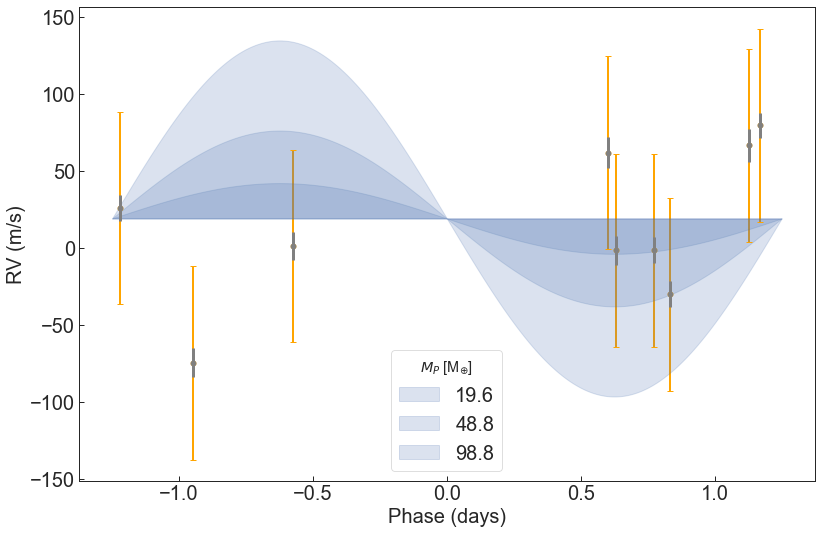

In [51]:
# pl.style.use('default')

fig, ax = pl.subplots(figsize=(12,8))

N = 5000
dt = 0.5
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase, idx = fold_index(t, Porb[0], tc=tc_new) 
phaseo, idxo = fold_index(df.bjd.values, Porb[0], tc=tc_new) 

ax.errorbar(phaseo, df.rv[idxo], df.rv_err[idxo], fmt='o', lw=3, zorder=3, color='gray') #, label='orig err'
ax.errorbar(phaseo, df.rv[idxo], rve, fmt='o', lw=2, zorder=1, capsize=3, color='orange') #, label='w/ jitter'

pctls = [68,95,99.7]
ks = np.percentile(df2.rv_k_1, pctls)

for i,k in zip(pctls,ks):
    Mp = get_Mp_from_K(Porb[0], Mstar[0], k, e=0, inc=np.pi/2).to(u.Mearth).value
    rv = rv_model(t, t0, Porb[0], e, w, k, k0)
    #rv_test = rv_model(df.bjd, t0, Porb[0], e, w, k, k0)
    
    #chisq = np.sum(((rv_test - df.rv)/(df.rv_err))**2)/8.
    #const = chisq**0.5
    
    ax.fill_between(phase, k0, rv[idx], '-', lw=1, label=f'{Mp:.1f}', color='C0', alpha=0.2)
    #ax.errorbar(phaseo, df.rv[idxo], df.rv_err*const, fmt='o', lw=2, zorder=1, capsize=3, color='orange') #, label='w/ jitter'

    
#pl.legend(title='$M_P$ [M$_{\oplus}$] (percentile)', markerscale=4, loc='lower center', fontsize=20)
pl.legend(title='$M_P$ [M$_{\oplus}$]', markerscale=4, loc='lower center', fontsize=20)

ax.set_xlabel('Phase (days)',fontsize=20)
ax.set_ylabel('RV (m/s)',fontsize=20)

pl.setp(ax.get_xticklabels(), fontsize=20)
pl.setp(ax.get_yticklabels(), fontsize=20)

fig.tight_layout()

In [66]:
best_K=pv[6]
best_K

14.407134999188926

/usr/local/Caskroom/miniconda/base/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [-1.2497824320637285 -1.2494723984004246 -1.2487090289489018 ...
 1.2493118626965298 1.2497651984847487 1.2500752321480526] in fill_betweenx(). This will become an error two minor releases later.


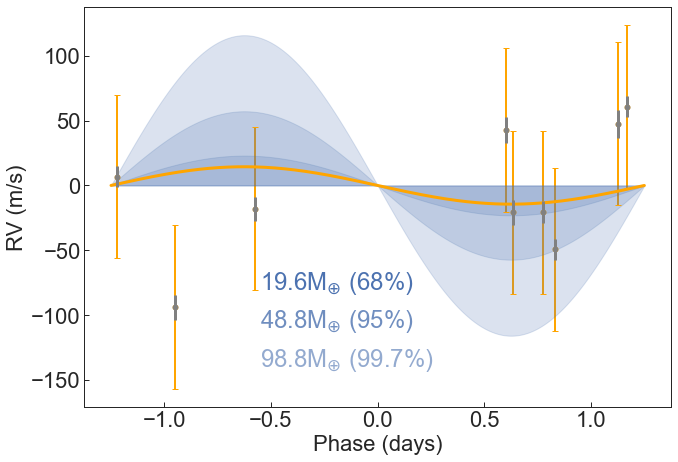

In [71]:
# pl.style.use('default')

fig, ax = pl.subplots(figsize=(10,7))

N = 5000
dt = 0.5
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase, idx = fold_index(t, Porb[0], tc=tc_new) 
phaseo, idxo = fold_index(df.bjd.values, Porb[0], tc=tc_new) 

ax.errorbar(phaseo, df.rv[idxo]-k0, df.rv_err[idxo], fmt='o', lw=3, zorder=3, color='gray') #, label='orig err'
ax.errorbar(phaseo, df.rv[idxo]-k0, rve, fmt='o', lw=2, zorder=1, capsize=3, color='orange') #, label='w/ jitter'

pctls = [68,95,99.7]
ks = np.percentile(df2.rv_k_1, pctls)

lb_offset=30
n=0
for i,k, al in zip(pctls,ks, [1, 0.8, 0.6]):
    Mp = get_Mp_from_K(Porb[0], Mstar[0], k, e=0, inc=np.pi/2).to(u.Mearth).value
    rv = rv_model(t, t0, Porb[0], e, w, k, 0)
    #ax.plot(phase, rv[idx], '-', lw=1, label=f'{Mp:.1f} ({i}%)', color='deepskyblue')
    ax.fill_between(phase, 0, rv[idx], '-', lw=1, label=f'{Mp:.1f} ({i}%)', color='C0', alpha=0.2)
    pl.text(-0.55, -80-n*lb_offset, f'{Mp:.1f}'+r'M$_{\oplus}$ '+f'({i}%)' , color='C0', alpha=al, fontsize=24)
#pl.legend(title='$M_P$ [M$_{\oplus}$] (percentile)', markerscale=4, loc='lower center', fontsize=20)
#pl.setp(ax, xlabel='Phase (days)', ylabel='RV (m/s)', 
#          xlim=(-Porb[0]/2, Porb[0]/2)
#       
    n+=1

best_Mp = get_Mp_from_K(Porb[0], Mstar[0], best_K, e=0, inc=np.pi/2).to(u.Mearth).value
best_rv = rv_model(t, t0, Porb[0], e, w, best_K, 0)
ax.plot(phase, best_rv[idx], '-', lw=3, label=f'{best_Mp:.1f} (best)', color='orange')


#pl.text( -0.5, -100,'$M_P$ [M$_{\oplus}$] (percentile)', fontsize=18)

ax.set_xlabel('Phase (days)',fontsize=22)
ax.set_ylabel('RV (m/s)',fontsize=22)

pl.setp(ax.get_xticklabels(), fontsize=22)
pl.setp(ax.get_yticklabels(), fontsize=22)

fig.tight_layout()

In [72]:
fp = f"../paper/figures/RV_comp_{band}.png"
if use_tc_offset:
    fp = f"../paper/figures/RV_comp_{band}_tc_offset.png"
fig.savefig(fp, bbox_inches="tight")

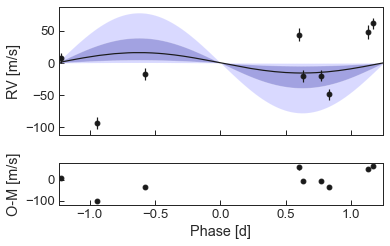

In [73]:
fig = lpf.plot_rv_vs_phase(planet=0, method='mcmc', ntimes=500)

In [74]:
fp = f"../paper/figures/RV_comp2_{band}.png"
if use_tc_offset:
    fp = f"../paper/figures/RV_comp2_{band}_tc_offset.png"
fig.savefig(fp, bbox_inches="tight")

In [75]:
import astropy.units as u

kmax = ks[1]
get_Mp_from_K(Porb[0], Mstar[0], kmax, e=0, inc=np.pi/2).to(u.Mjup)

<Quantity 0.15351502 jupiterMass>